# Object Detection Notebook using IceVision

Using Singularity container w/ IceVision v0.5.2 (https://airctic.com/0.5.2/)

In [1]:
from icevision.all import *
import pandas as pd
import numpy as np

In [2]:
#set directories
root_dir = "/work/ih49/simulations/"
base_dir = root_dir + 'AIMs/'

#testing run on full ancestry images
path = Path(base_dir + 'full_ancestry/')

In [3]:
fnames = get_image_files(path)

Calculate bounding box vertices as 5 pixels +/- the variant position. Variant location (physical position) is taken from the image file name, and converted to pixel coordinates.

Bbox is formated as \[xmin, ymin, xmax, ymax\], with indices started at 0 from the bottom left corner.

In [4]:
pos = [int(re.search("pos-(.*)_seed", str(i)).group(1)) for i in fnames]
bbox_xmin = [math.ceil((i / 50e6) * 200) - 5 for i in pos]
labl_bbox = [[i, 0, i + 11, 200] for i in bbox_xmin]
image_id = [re.search("(.*.png)", str(i)).group(1) for i in fnames]

Combine image filename, image width, image height, bbox, and source \[which is the "images" directory\] in dataframe (for input to icevision parser).

In [5]:
df = pd.DataFrame(list(zip(image_id, [200] * len(image_id), [200] * len(image_id), labl_bbox, [str(path) for i in image_id])), 
               columns =['image_id', 'width', 'height', 'bbox', 'source'])

Creat custom parser. I followed [this tutorial](https://airctic.com/0.5.2/custom_parser/) with some modifications.

In [6]:
class VariantParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [7]:
VariantParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [8]:
class VariantParser(parsers.FasterRCNN, parsers.FilepathMixin, parsers.SizeMixin):
    def __init__(self, df, source):
        self.df = df
        self.source = source

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> Hashable:
        return o.image_id

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}"

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[int]:
        return [1]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xyxy(*np.fromiter(o.bbox, dtype="int"))]

Create class map. This is necessary, even though there is only one class.

In [9]:
class_map = ClassMap(['selected_variant'])

Split data to training and validation records. I set a random seed so we can be comparing with the same train/valid sets. 8000 images in training set, 2000 in validation set.

This may take a couple minutes to run.

In [10]:
parser = VariantParser(df, path)
train_rs, valid_rs = parser.parse(data_splitter=RandomSplitter([0.8, 0.2], seed=42))

Make sure everything looks correct.

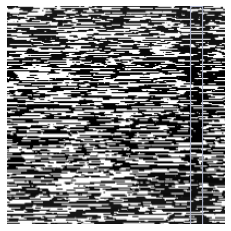

In [11]:
show_record(train_rs[60], display_label=False)

In [12]:
len(train_rs), len(valid_rs)

(8000, 2000)

In [13]:
train_ds = Dataset(train_rs)
valid_ds = Dataset(valid_rs)

Create dataloaders and define the model we're using ([FasterRCNN](https://airctic.com/0.5.2/model_faster_rcnn/), resnet18 architecture)

In [14]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [15]:
backbone = faster_rcnn.backbones.resnet_fpn.resnet18(pretrained=True)
model = faster_rcnn.model(backbone=backbone, num_classes=len(class_map))

Define custom metrics & wrap in Metric class

* Center proportion (center_metric) = proportion of predicted bboxes that contain the selected variant. (should be close to 1)
* Average width (width_metric) = average width of bboxes (should be ~11 pixels wide)
* Number of boxes (num_bboxes) = average number of predicted bboxes per image (should be close to 1)
* Precision & Recall = each x-axis pixel position as an independent test. positions within the x-min and x-max of the predicted bounding box are positive classifications ("selection") & x-axis positions outside the predicted bounding box are negative classifications ("neutral")

In [16]:
def center_metric(sample, pred):
  bbox_pred = pred['bboxes']
  if len(bbox_pred)>0:
    bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
    bbox_sample = sample['bboxes'][0]
    bbox_xaxis_sample = bbox_sample.xyxy[0:3:2]
    sample_midpoint = math.ceil((bbox_xaxis_sample[0] + bbox_xaxis_sample[1])/2)
    center_in_bbox = [i[1] >= sample_midpoint >= i[0] for i in bbox_xaxis_pred]
    center_accuracy_mean = np.mean(center_in_bbox)
  else:
    center_accuracy_mean = 0
  return center_accuracy_mean

def width_metric(pred):
  bbox_pred = pred['bboxes']
  if len(bbox_pred)>0:
    bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
    pred_width = [i[1] - i[0] for i in bbox_xaxis_pred]
    pred_width_mean = np.mean(pred_width)
  else:
    pred_width_mean = None
  return pred_width_mean
  

def num_bboxes(pred):
  num_boxes = len(pred['bboxes'])
  return num_boxes

In [17]:
def precision_recall_metric(samples, preds, detection_threshold=0.5):
    sample_all_true = []
    pred_all_true = []
    for i in range(len(samples)):
        sample_bbox_true = [0] * 200
        sample_bbox_xmin, sample_bbox_xmax = samples[i]['bboxes'][0].xyxy[0:3:2]
        sample_bbox_true[sample_bbox_xmin:sample_bbox_xmax] = [1] * (sample_bbox_xmax - sample_bbox_xmin)
        sample_all_true.extend(sample_bbox_true)
        
        pred_bbox_true = [0] * 200
        bbox_pred = [preds[i]['bboxes'][e] for e in range(len(preds[i]['scores'])) if preds[i]['scores'][e] >= detection_threshold]
        if len(bbox_pred)>0:
            bbox_xaxis_pred = [bbox.xyxy[0:3:2] for bbox in bbox_pred]
            for j in bbox_xaxis_pred:
                bbox_min = round(j[0])
                bbox_max = round(j[1])
                if bbox_min < 0:
                    bbox_min = 0
                if bbox_max > 200:
                    bbox_max = 200
                pred_bbox_true[bbox_min:bbox_max] = [1] * (bbox_max - bbox_min)        
        pred_all_true.extend(pred_bbox_true)
    bbox_precision = precision_score(sample_all_true, pred_all_true, zero_division=1)
    bbox_recall = recall_score(sample_all_true, pred_all_true)
    return_dict = {"Precision": bbox_precision, "Recall": bbox_recall, "Threshold": detection_threshold}
    return return_dict

For all metrics, the idea here is to calculate the metric for all validation records (2000 images) and collect them by batches (accumulate), and average across all records at the end of each epoch (finalize). Then, the accumulated metrics need to be cleared at the end of each epoch so that they can be calculated anew the next cycle.

For average widths: some records will have no predicted bboxes, so the average is not calculated for those values. That is, we calculate the average width only for those bboxes that are predicted. So the denominator may be more or less than the actual number of valiation records. This value will likely be None in the first epoch because no bboxes will be predicted.

In [18]:
class Center_Proportion(Metric):
    def __init__(self):
        self._props = []

    def _reset(self):
        self._props.clear()

    def accumulate(self, records, preds):
        center_results = [center_metric(sample, pred) for sample, pred in zip(records,preds)]
        self._props.extend(center_results)

    def finalize(self) -> Dict[str, float]:
        final_prop = np.mean(self._props)
        self._reset()
        return {'Center_in_Bbox': final_prop}

class Avg_Width(Metric):
    def __init__(self):
        self._widths = []

    def _reset(self):
        self._widths.clear()

    def accumulate(self, records, preds):
        width_results = [width_metric(pred) for pred in preds]
        for i in width_results:
          if i:
            self._widths.append(i)
          else:
            pass

    def finalize(self) -> Dict[str, float]:
        if self._widths:
          final_avg = np.mean(self._widths)
        else:
          final_avg = None
        self._reset()
        return {'Width_Bbox': final_avg}

class Num_Bboxes(Metric):
    def __init__(self):
        self._num = []

    def _reset(self):
        self._num.clear()

    def accumulate(self, records, preds):
        num_boxes_results = [num_bboxes(pred) for pred in preds]
        self._num.extend(num_boxes_results)

    def finalize(self) -> Dict[str, float]:
        final_num = np.mean(self._num)
        self._reset()
        return {'Num_Bbox': final_num}

### Training the model (skip this section if loading existing weights!)

Define the fastai learner, specifying metrics. I included COCOMetric(), which is commonly used for bboxes. It is essentialy IoU.

We could also use PyTorch Lightening instead of FastAI, but I'm sticking with FastAI since we're familiar with it.

In [19]:
metrics = [COCOMetric(), Num_Bboxes(), Center_Proportion(), Avg_Width()]
learn = faster_rcnn.fastai.learner(
    dls=[train_dl, valid_dl], model=model, metrics=metrics
)

Keep in mind that metric values don't seem to match the true values when we export the model and infer/predict on our validation set. I'm still not clear why the numbers don't match.

This will take ~10-15 min to train for 1k images (may also depend on your node/available mem?). For 10k images, it took ~1.5 hours.

In [20]:
learn.fine_tune(30, base_lr=3e-3, freeze_epochs=1, wd=1e-2)

epoch,train_loss,valid_loss,COCOMetric,Num_Bboxes,Center_Proportion,Avg_Width,time
0,2.045280,2.044360,0.000000,0.001500,0.000500,45.62151,02:08


epoch,train_loss,valid_loss,COCOMetric,Num_Bboxes,Center_Proportion,Avg_Width,time
0,0.125499,0.129716,0.433199,5.650000,0.682338,11.035578,02:50
1,0.106207,0.111931,0.490759,2.660000,0.827562,11.088429,02:52
2,0.096827,0.093063,0.530733,2.697000,0.776439,10.659368,02:56
3,0.087242,0.093608,0.490780,2.315500,0.798260,10.823232,02:56
4,0.078552,0.075652,0.501334,2.330500,0.830341,10.870611,02:52
5,0.082204,0.074298,0.576439,3.033000,0.828057,10.554005,03:02
6,0.073781,0.068312,0.556714,2.212500,0.881156,10.761017,03:00
7,0.071663,0.070319,0.559197,2.614500,0.835317,10.399689,02:52
8,0.067170,0.073874,0.592331,3.468000,0.799762,11.020411,02:50
9,0.108626,0.093580,0.460591,1.375000,0.896050,10.865683,02:48


Run inference on the validation set. Confirm accuracy with each of the relevant metrics.

In [21]:
infer_dl = faster_rcnn.infer_dl(valid_ds, batch_size=16)
samples, preds = faster_rcnn.predict_dl(model, infer_dl)

  0%|          | 0/125 [00:00<?, ?it/s]

Predictions include a score (can interpret as posterior probability), but by default only reports predictions with the score above the threshold (which is 0.5). You can modify this detection threshhold:

```samples, preds = faster_rcnn.predict_dl(model2.cuda(), infer_dl, detection_threshold=0)```

This way you can use the scores to generate a true ROC or Precision-Recall curve.

In [22]:
center_results = [center_metric(sample, pred) for sample, pred in zip(samples,preds)]
num_boxes_results = [num_bboxes(pred) for pred in preds]
width_results = [width_metric(pred) for pred in preds]
final_widths = []
for i in width_results:
    if i:
      final_widths.append(i)
    else:
      pass
np.mean(center_results), np.mean(num_boxes_results), np.mean(final_widths), precision_recall_metric(samples, preds)

(0.97775,
 1.014,
 10.815544,
 'Precision: 0.9145858288030959; Recall: 0.915598192048704')

Pretty good! We're averaging 1 predicted bounding box per image, the variant is detected w/in the bounding boxes for ~95% of validation images, and the average bounding box has a width of ~11 pixels!

(Earlier note: w/ the 25 megabase s=0.05 images (1k total), I trained this exact same model 3 times to confirm, and the avg center proportion metric is 90.6%, num boxes ~1.02, and avg box width ~10.83 pixels. These results were consistent and had low variance across the three replicates, so I'm fairly confident you should get approximately the same accuracy in training.)

Only trained once for this larger dataset

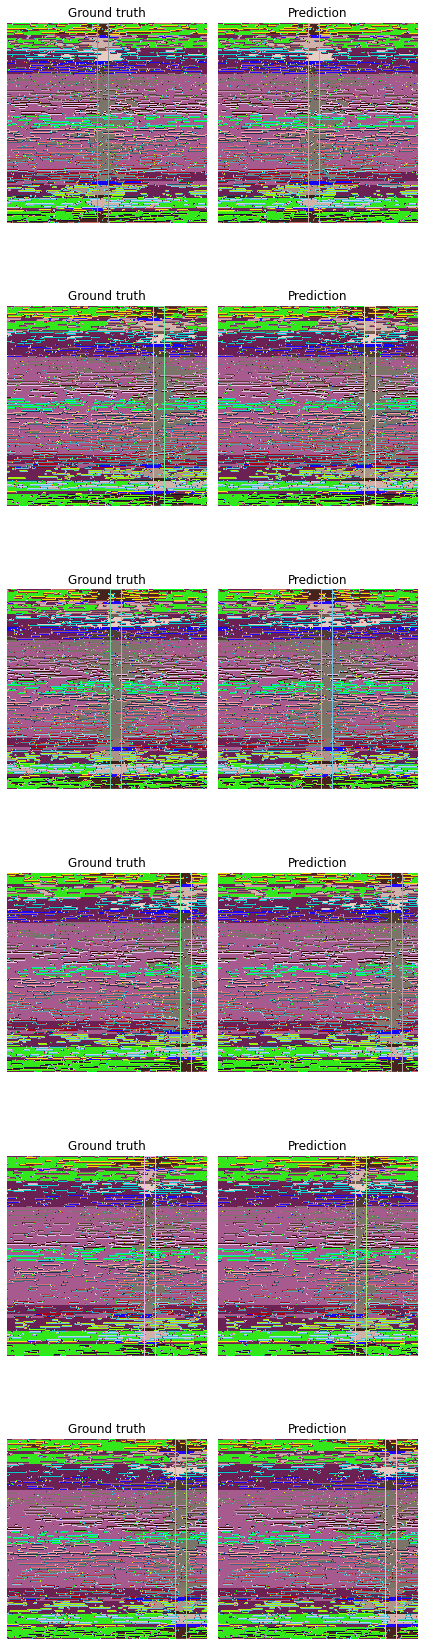

In [25]:
show_preds(samples[:6], preds[:6], class_map, display_label=False, display_mask=False)

Save the model weights so we can reload them later! Good so we can recalculate performance metrics without having to retrain the model. **Make sure not to save over an existing model weight file!!**

In [26]:
torch.save(model.state_dict(), 'object_localization_full-ancestry.model.pth')

Save the predictions and targets as well.

In [27]:
pd.DataFrame(preds).to_csv("object_localization_full_ancestry_preds.txt", sep='\t', header=True, index=False)

In [28]:
pd.DataFrame(samples).to_csv("object_localization_full_ancestry_targets.txt", sep='\t', header=True, index=False, columns=['imageid','bboxes','labels','filepath'])

### Skip training and start here to load model weights!

In [19]:
model2 = faster_rcnn.model(backbone=backbone, num_classes=len(class_map))
model2.load_state_dict(torch.load('object_localization_full-ancestry.model.pth', map_location=torch.device('cuda')))

<All keys matched successfully>

Make sure results are the same when loading the pretrained weights.

In [21]:
infer_dl = faster_rcnn.infer_dl(valid_ds, batch_size=16)
samples, preds = faster_rcnn.predict_dl(model2.cuda(), infer_dl)

  0%|          | 0/125 [00:00<?, ?it/s]

In [22]:
center_results = [center_metric(sample, pred) for sample, pred in zip(samples,preds)]
num_boxes_results = [num_bboxes(pred) for pred in preds]
width_results = [width_metric(pred) for pred in preds]
final_widths = []
for i in width_results:
    if i:
      final_widths.append(i)
    else:
      pass
np.mean(center_results), np.mean(num_boxes_results), np.mean(final_widths), precision_recall_metric(samples, preds)

(0.97775,
 1.014,
 10.815544,
 'Precision: 0.9145858288030959; Recall: 0.915598192048704')

Looking good!!!!